In [4]:
#%%writefile code/DeepNerualNet_BGD.py
#%load code/DeepNeuralNet_BGD.py
class DeepNeuralNet_BGD(object):
    """ implements a deep neural net. 
        Users may specify any number of layers.
        net_arch -- consists of a number of neurons in each layer 
    """
    def __init__(self, net_arch, activate = None, eta = 1.0, epochs = 100, random_seed = 1):
        
        if not isinstance(net_arch, list):
            sys.exit('Use a list to list number of neurons in each layer.')
        if len(net_arch) < 3:
            sys.exit('Specify the number of neurons more than two layers.')
                     
        self.eta = eta
        self.epochs = epochs
        self.net_arch = net_arch
        self.layers = len(net_arch)
        self.W = []
        self.random_seed = random_seed
        
        np.random.seed(self.random_seed)
        # Random initialization with range of weight values (-1,1)
        # A place holder None is used to indicated "unused place".
        self.W = [[None]]    ## the first W0 is not used.
        for layer in range(self.layers - 1):
            w = 2 * np.random.rand(self.net_arch[layer+1], 
                                   self.net_arch[layer]) - 1
            self.W.append(w)
        
        # initialize the activation function list with sigmoid() as default
        self.g = [lambda x: sigmoid(x) for _ in range(self.layers)]
        self.g_prime = [lambda x: sigmoid_d(x) for _ in range(self.layers)]
        
        # get the user-defined activation functions and their derivatives
        if activate is not None:
            if len(activate) % 2 != 0:
                sys.exit("List activation functions & its derivatives in pairwise")
            if len(activate) > (self.layers - 1) * 2:
                sys.exit("Too many activation functions & its derivatives encountered")
            for i, (g, g_prime) in enumerate(zip(activate[::2], activate[1::2])):
                self.g[i+1] = g
                self.g_prime[i+1] = g_prime
            
    def forpass(self, A0):     
        Z = [[None]] # Z0 is not used.
        A = []       # A0 = X0 is used. 
        A.append(A0)
        for i in range(1, len(self.W)):
            z = np.dot(self.W[i], A[i-1])
            Z.append(z)
            a = self.g[i](z)
            A.append(a)
        return Z, A
    
    def backprop(self, Z, A, Y):
        # initialize empty lists to save E and dZ
        # A place holder None is used to indicated "unused place".
        E  = [None for x in range(self.layers)]
        dZ = [None for x in range(self.layers)]
        
        # Get error at the output layer or the last layer
        ll = self.layers - 1
        error = Y - A[ll]
        E[ll] = error   
        dZ[ll] = error * self.g_prime[ll](Z[ll]) 
        
        # Begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            E[i]  = np.dot(self.W[i+1].T, E[i+1])
            dZ[i] = E[i] * self.g_prime[i](Z[i])
       
        # Adjust the weights 
        m = Y.shape[1]  # number of samples
        for i in range(ll, 0, -1):
            self.W[i] += self.eta * np.dot(dZ[i], A[i-1].T) / m
        return error
         
    def fit(self, X, y):
        self.cost_ = [] 
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.net_arch[-1]) 
        
        for epoch in range(self.epochs): 
            #if epoch % 20== 0:
            #    print('Training epoch {}/{}'.format(epoch+1, self.epochs))

            A0 = np.array(X, ndmin=2).T   # A0 : inputs, minimum 2d array
            Y0 = np.array(Y, ndmin=2).T   # Y: targets

            Z, A = self.forpass(A0)          # forward pass
            cost = self.backprop(Z, A, Y0)   # back propagation
            self.cost_.append(np.sqrt(np.sum(cost * cost)))
        return self

    def predict(self, X):  # used in plot_decsion_regions()          
        Z, A2 = self.forpass(X)
        A2 = np.array(A2[len(A2)-1])
        return A2[-1] > 0.5
    
    def predict_(self, X): # used in evaluate() 
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z, A = self.forpass(A0)             # forpass
        return A[-1]                                       
   
    def evaluate(self, Xtest, ytest):       # fully vectorized calculation
        m_samples = len(ytest)
        scores = 0        
        A3 = self.predict_(Xtest)
        yhat = np.argmax(A3, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

In [5]:
import numpy as np

def tanh(x):
    return (1.0 - np.exp(-2*x))/(1.0 + np.exp(-2*x))

def tanh_d(x):
    return (1 + tanh(x))*(1 - tanh(x))

def sigmoid(x): 
    x = np.clip(x, -500, 500)  
    return 1/(1 + np.exp((-x)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x, 0)

def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [6]:
import joy
X, Y = joy.gaussian_quantiles(random_seed=1)
nn1 = DeepNeuralNet_BGD([2, 100, 2], eta=0.2, epochs=2000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))

Accuracy 55.50000000000001%


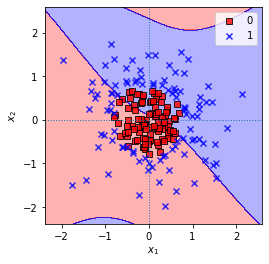

In [9]:
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn1.predict(z.T))

In [7]:
import joy
X, Y = joy.gaussian_quantiles(random_seed = 1)
nn2 = DeepNeuralNet_BGD([2, 60, 30, 10, 2], eta=0.2, epochs=2000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 99.5%


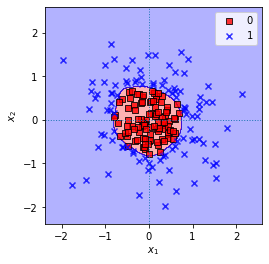

In [10]:
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn2.predict(z.T))

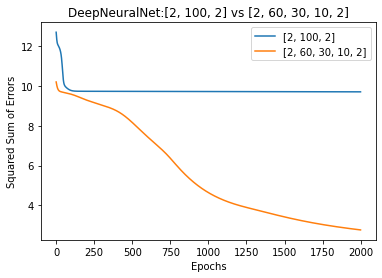

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

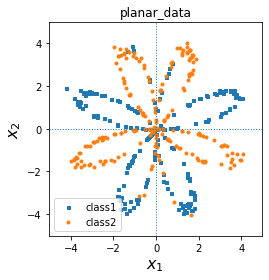

In [11]:
import joy
X, Y = joy.planar_data()
joy.plot_xyw(X.T, Y.squeeze(), title="planar_data")

In [12]:
import joy
X, y = joy.planar_data()
nn1 = DeepNeuralNet_BGD([2, 150, 2], eta=0.3, epochs=5000)
nn1.fit(X.T, y.flatten())
accuracy = nn1.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 87.5%


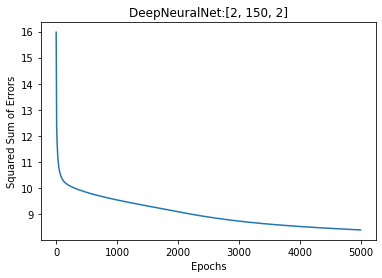

In [14]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()

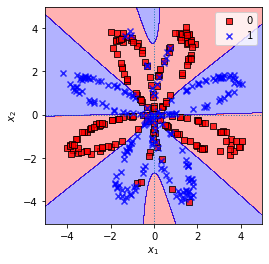

In [17]:
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn1.predict(z.T))

In [13]:
import joy
X, y = joy.planar_data()
nn2 = DeepNeuralNet_BGD([2, 100, 30, 20, 2], eta=0.3, epochs=5000)
nn2.fit(X.T, y.flatten())
accuracy = nn2.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 91.25%


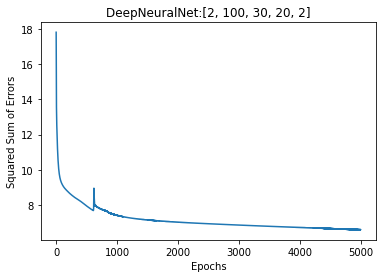

In [16]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

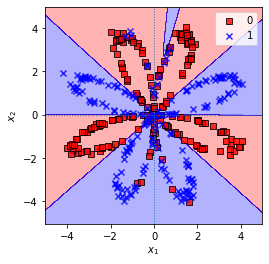

In [18]:
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn2.predict(z.T))

Converting fashion-train-images-idx3-ubyte.gz to NumPy Array ...Done
Converting fashion-train-labels-idx1-ubyte.gz to NumPy Array ...Done
Converting fashion-t10k-images-idx3-ubyte.gz to NumPy Array ...Done
Converting fashion-t10k-labels-idx1-ubyte.gz to NumPy Array ...Done
Creating pickle file ...Done!


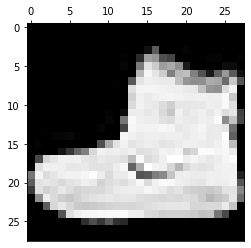

<Figure size 432x288 with 0 Axes>

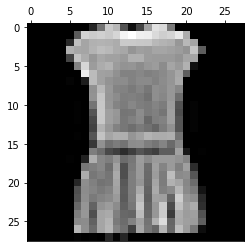

<Figure size 432x288 with 0 Axes>

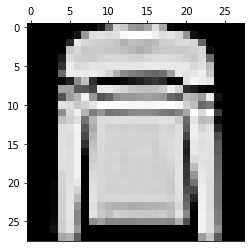

<Figure size 432x288 with 0 Axes>

In [19]:
import joy
import matplotlib.pyplot as plt
(X, y), (Xt, yt) = joy.load_fashion_mnist(
                normalize=False, flatten=False)
joy.show_mnist(X[0], savefig = 'Fashion-MNIST1')
joy.show_mnist(X[3], savefig = 'Fashion-MNIST1')
joy.show_mnist(X[5], savefig = 'Fashion-MNIST1')

In [20]:
(X, y), (Xtest, ytest) = joy.load_fashion_mnist()     
nn1 = DeepNeuralNet_BGD([784, 100, 10], 
                       eta = 0.1, epochs = 1000)  
nn1.fit(X[:6000], y[:6000])
accuracy = nn1.evaluate(Xtest[:1000], ytest[:1000])
print('Accuracy {}%'.format(accuracy))

Accuracy 75.6%


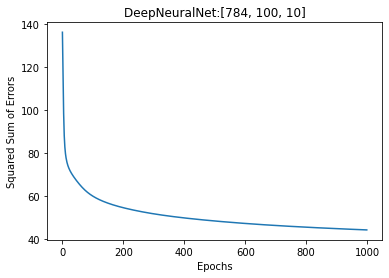

In [22]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()

In [21]:
(X, y), (Xtest, ytest) = joy.load_fashion_mnist()     
nn2 = DeepNeuralNet_BGD([784, 200, 100, 50, 10],
                       eta = 0.1, epochs = 1000)  
nn2.fit(X[:6000], y[:6000])
accuracy = nn2.evaluate(Xtest[:1000], ytest[:1000])
print('Accuracy {}%'.format(accuracy))

Accuracy 83.2%


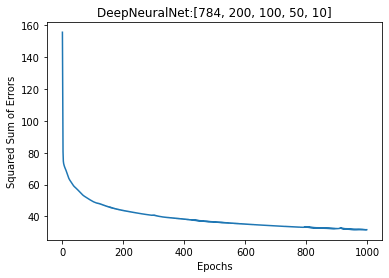

In [23]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

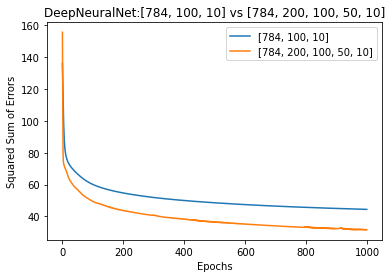

In [24]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

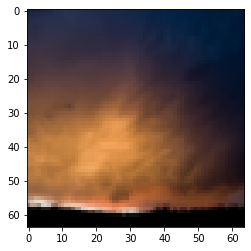

In [38]:
import joy
X, y, Xtest, ytest, classes = joy.load_cat_data()
plt.imshow(X[0])

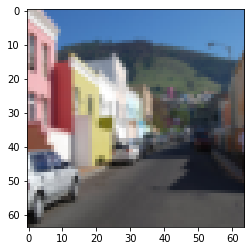

In [39]:
plt.imshow(X[1])

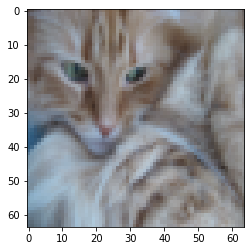

In [40]:
plt.imshow(X[2])

In [41]:
print("Number of train examples:", X.shape[0])
print("Number of test  examples:", Xtest.shape[0])
print("One image size:({}, {}, {})".
      format(X.shape[1], X.shape[1], 3))
print("train X shape:", X.shape)
print("train y shape:", y.shape)
print("test  X shape:", Xtest.shape)
print("test  y shape:", ytest.shape)

Number of train examples: 209
Number of test  examples: 50
One image size:(64, 64, 3)
train X shape: (209, 64, 64, 3)
train y shape: (1, 209)
test  X shape: (50, 64, 64, 3)
test  y shape: (1, 50)


In [42]:
X_flatten = X.reshape(X.shape[0], -1)  
Xtest_flatten = Xtest.reshape(Xtest.shape[0], -1)
X = X_flatten/255.
Xtest = Xtest_flatten/255.
print ("train X shape:", X.shape)
print ("test  X shape:", Xtest.shape)

train X shape: (209, 12288)
test  X shape: (50, 12288)


In [49]:
import joy
dnn = DeepNeuralNet_BGD([12288, 100, 50, 2], eta = 0.3, epochs = 167)  
dnn.fit(X, y.flatten())
self = dnn.evaluate(X, y.flatten())
print('Accuracy self: {}%'.format(np.round(self, 2)))

Accuracy self: 87.08%


In [50]:
import joy
dnn = DeepNeuralNet_BGD([12288, 100, 50, 2], eta = 0.3, epochs = 167)  
dnn.fit(X, y.flatten())
test = dnn.evaluate(Xtest, ytest.flatten())
print('Accuracy self: {}%'.format(np.round(test, 2)))

Accuracy self: 80.0%


In [48]:
import joy

for epoch in range(150, 180):
    dnn = DeepNeuralNet_BGD([12288, 100, 50, 2], eta = 0.3, epochs = epoch)  
    dnn.fit(X, y.flatten())   
    self = dnn.evaluate(X, y.flatten()) 
    test = dnn.evaluate(Xtest, ytest.flatten()) 
    print('Accuracy({}) self: {}%, test: {}%'.
          format(epoch, np.round(self, 2), np.round(test, 2)))

Accuracy(150) self: 90.91%, test: 76.0%
Accuracy(151) self: 84.21%, test: 38.0%
Accuracy(152) self: 96.17%, test: 68.0%
Accuracy(153) self: 89.0%, test: 44.0%
Accuracy(154) self: 93.78%, test: 64.0%
Accuracy(155) self: 94.26%, test: 48.0%
Accuracy(156) self: 95.22%, test: 58.0%
Accuracy(157) self: 95.69%, test: 58.0%
Accuracy(158) self: 97.13%, test: 54.0%
Accuracy(159) self: 96.17%, test: 56.0%
Accuracy(160) self: 96.65%, test: 50.0%
Accuracy(161) self: 96.17%, test: 54.0%
Accuracy(162) self: 97.13%, test: 52.0%
Accuracy(163) self: 96.65%, test: 62.0%
Accuracy(164) self: 91.39%, test: 48.0%
Accuracy(165) self: 94.74%, test: 74.0%
Accuracy(166) self: 85.65%, test: 38.0%
Accuracy(167) self: 87.08%, test: 80.0%
Accuracy(168) self: 81.34%, test: 38.0%
Accuracy(169) self: 89.0%, test: 78.0%
Accuracy(170) self: 78.95%, test: 32.0%
Accuracy(171) self: 83.73%, test: 76.0%
Accuracy(172) self: 76.08%, test: 38.0%
Accuracy(173) self: 90.43%, test: 76.0%
Accuracy(174) self: 81.82%, test: 42.0%
Ac

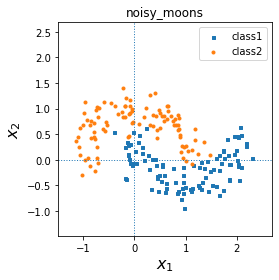

In [51]:
import joy
%matplotlib inline
X, Y = joy.noisy_moons()
joy.plot_xyw(X.T, Y.squeeze(), title="noisy_moons")

Accuracy 85.5%


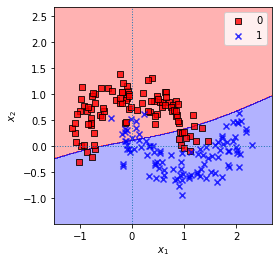

In [53]:
X, Y = joy.noisy_moons()
nn1 = DeepNeuralNet_BGD([2,200,2], eta=0.2, epochs=1000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn1.predict(z.T))

In [54]:
X, Y = joy.noisy_moons()
accuracies = []
for hnode in range(100, 300, 20):
    for epoch in range(200, 1000, 100):
        nn1 = DeepNeuralNet_BGD([2,hnode,2], eta=0.2, epochs=epoch)
        nn1.fit(X.T, Y.flatten())
        accuracy = nn1.evaluate(X.T, Y.flatten())
        accuracies.append((np.round(accuracy, 1), hnode, epoch))

In [57]:
accuracies.sort(key = lambda tup: tup[0])
print(accuracies[:4])
print(accuracies[-4:])
print('Max Accuracy:', accuracies[-1])
print('Max Accuracy {}% at (hnode, epoch)=({},{})'
      .format(accuracies[-1][0], accuracies[-1][1], accuracies[-1][2]))

[(85.0, 100, 500), (85.0, 100, 600), (85.0, 100, 700), (85.0, 100, 800)]
[(85.5, 280, 500), (86.0, 100, 300), (86.0, 120, 200), (86.0, 140, 200)]
Max Accuracy: (86.0, 140, 200)
Max Accuracy 86.0% at (hnode, epoch)=(140,200)


In [73]:
nn1 = DeepNeuralNet_BGD([2,200,2], eta=0.2, epochs=5000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 86.5%


Accuracy 87.0%


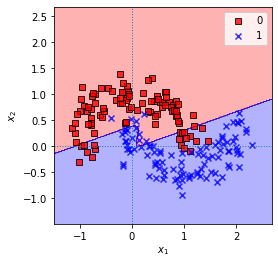

In [71]:
X, Y = joy.noisy_moons()
nn2 = DeepNeuralNet_BGD([2,170,20,10,2], eta=0.2, epochs=5000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn2.predict(z.T))

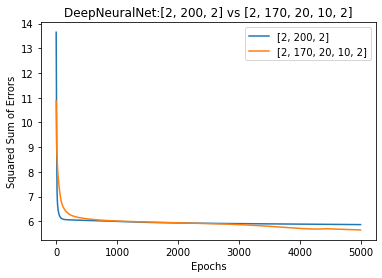

In [74]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

In [95]:
import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [85]:
from keras.datasets import mnist
(X, y), (Xtest, ytest) = mnist.load_data()

In [89]:
import torch
import torchvision.datasets as dset
root = "./data"
train_set = dset.MNIST(root=root, train=True, download=True)
test_set = dset.MNIST(root=root, train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/Users/younhongko/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [93]:
import tensorflow.compat.v1 as tf

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

tf.disable_v2_behavior() 

x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
dropout_ratio = tf.placeholder(tf.float32)

x_train = tf.reshape(x, [-1, 28, 28, 1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_train, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, dropout_ratio)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_hat = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [96]:
CE = tf.reduce_mean(
        -tf.reduce_sum(y * tf.log(y_hat), reduction_indices=[1])
     )
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(CE)
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(10):
        batch = mnist.train.next_batch(32)
        if i%100 == 0:
            train_accuracy = accuracy.eval(session=sess, feed_dict={
                x:batch[0], y: batch[1], dropout_ratio: 1.0
            })
            print("step %d, training accuracy %g"%(i, train_accuracy))
        train_step.run(feed_dict={x: batch[0], y: batch[1], dropout_ratio: 0.2})
    
    acc = sess.run(accuracy, feed_dict={x:mnist.test.images, y:mnist.test.labels, dropout_ratio: 1.0})
    print("Test accuracy: {}".format(acc))

step 0, training accuracy 0.0625
Test accuracy: 0.2874000072479248


In [107]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=2)
        self.conv1_drop = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=2)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=2)
        self.conv3_drop = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(256, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = x.view(-1, 256)
        x = self.fc1(x)
        
        return F.log_softmax(x)

In [108]:
n_epochs = 10
learning_rate = 0.01
random_seed = 1
log_interval = 10

network = Net()
optimizer = optim.RMSprop(network.parameters(), lr=learning_rate)

In [112]:
import torch
from torchvision import datasets, transforms

use_cuda = not False and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
        batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
        batch_size=64, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [109]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            

In [110]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = network(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
    print('Test Accuracy {}%\n'.format(100.*correct / len(test_loader.dataset)))

In [113]:
for epoch in range(1, n_epochs+1):
    train(epoch)
    test()

<ipython-input-107-4d68800bd04f>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298218
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295110
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.232027
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.789136
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.237067
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.104636
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.173412
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.844244
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.973052
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.976932
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.041214
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.778624
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.574814
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.512245
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.933114
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.488445
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.570830
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.487237
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.604184
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.750152
Train Epoch: 1 [12800/60000 (

/Users/younhongko/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Accuracy 96.19999694824219%

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.350475
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.217698
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.292703
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.352844
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.349262
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.144432
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.264812
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.218816
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.297095
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.375735
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.233618
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.217887
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.156601
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.197168
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.274311
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.195635
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.100936
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.159267
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.232326
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.17

Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.471773
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.119179
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.194966
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.330522
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.103814
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.323051
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.216249
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.355244
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.120757
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.265885
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.138977
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.230609
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.114859
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.172789
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.300881
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.217398
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.026346
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.287568
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.196608
Train Epoch: 3 [56960/60000 (95%)]	Loss: 0.084895


Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.258210
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.296640
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.441713
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.387805
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.265734
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.202179
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.116177
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.292709
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.155490
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.161596
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.132236
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.231755
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.272411
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.339400
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.144013
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.238082
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.124772
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.209530
Train Epoch: 5 [40960/60000 (68%)]	Loss: 0.117449
Train Epoch: 5 [41600/60000 (69%)]	Loss: 0.148570


Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.268331
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.148810
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.282371
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.400735
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.172669
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.321880
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.145878
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.129517
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.388744
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.071449
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.060049
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.317753
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.102485
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.143734
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.112711
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.272278
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.118246
Train Epoch: 7 [24960/60000 (42%)]	Loss: 0.078525
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.225985
Train Epoch: 7 [26240/60000 (44%)]	Loss: 0.153576


Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.156511
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.158233
Test Accuracy 97.26000213623047%

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.070901
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.356691
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.099748
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.266353
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.076397
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.195717
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.062517
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.331960
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.071965
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.336764
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.110224
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.102840
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.162933
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.208395
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.305274
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.318912
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.133519
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.25

Train Epoch: 10 [42880/60000 (71%)]	Loss: 0.245407
Train Epoch: 10 [43520/60000 (72%)]	Loss: 0.216279
Train Epoch: 10 [44160/60000 (74%)]	Loss: 0.132465
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.434389
Train Epoch: 10 [45440/60000 (76%)]	Loss: 0.195573
Train Epoch: 10 [46080/60000 (77%)]	Loss: 0.316851
Train Epoch: 10 [46720/60000 (78%)]	Loss: 0.192445
Train Epoch: 10 [47360/60000 (79%)]	Loss: 0.123053
Train Epoch: 10 [48000/60000 (80%)]	Loss: 0.225740
Train Epoch: 10 [48640/60000 (81%)]	Loss: 0.166710
Train Epoch: 10 [49280/60000 (82%)]	Loss: 0.098894
Train Epoch: 10 [49920/60000 (83%)]	Loss: 0.187422
Train Epoch: 10 [50560/60000 (84%)]	Loss: 0.233882
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.243908
Train Epoch: 10 [51840/60000 (86%)]	Loss: 0.121040
Train Epoch: 10 [52480/60000 (87%)]	Loss: 0.039906
Train Epoch: 10 [53120/60000 (88%)]	Loss: 0.059302
Train Epoch: 10 [53760/60000 (90%)]	Loss: 0.108862
Train Epoch: 10 [54400/60000 (91%)]	Loss: 0.249865
Train Epoch: 10 [55040/60000 (9